In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39619")
client

Client Scheduler: tcp://127.0.0.1:39619 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 14 Cores: 70 Memory: 295.74 GB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from dask.diagnostics import ProgressBar
import os.path as op
import os
import xrft
import gsw
import time
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from MITgcmutils import jmd95
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from xlayers import finegrid, layers
from xlayers.core import layers_numpy, layers_apply

In [4]:
ddir = '/tank/chaocean/'
savedir = '/tank/topog/tuchida/TWA/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 10
yend = 50

xchunk = 250
ychunk = 400
membchunk = 1
dnf = 2160

In [6]:
ds = open_mdsdataset(op.join(ddir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (24,1965)), 
                     grid_dir=op.join(ddir,'grid_chaO/gridMIT_update1/'),
                     iters=1103760,
                     prefix=['diag_ocnSnap'], delta_t=2e2,
                    ).sel(YC=slice(ySstart-12**-1,yend+2*12**-1),
                          YG=slice(ySstart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})
ds

<xarray.Dataset>
Dimensions:  (XC: 1000, XG: 1000, YC: 783, YG: 783, Z: 46, Zl: 46, Zp1: 47, Zu: 46, time: 1)
Coordinates:
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) float64 2.208e+08
  * XC       (XC) >f4 262.00003 262.0861 262.17215 ... 347.88644 347.9725
  * YC       (YC) >f4 -15.0833 -14.999967 -14.916634 ... 50.000034 50.08337
  * XG       (XG) >f4 261.957 262.04306 262.12912 ... 347.8434 347.92947
  * YG       (YG) >f4 -15.041634 -14.9583 -14.874967 ... 50.041702 50.125034
  * Z        (Z) >f4 -3.0467727 -9.454049 -16.363966 ... -5624.9517 -5875.141
  * Zp1      (Zp1) >f4 0.0 -6.0935454 -12.814552 ... -5749.9097 -6000.3726
  * Zu       (Zu) >f4 -6.0935454 -12.814552 -19.91338 ... -5749.9097 -6000.3726
  * Zl       (Zl) >f4 0.0 -6.0935454 -12.814552 ... -5499.9937 -5749.9097
    rA       (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxG      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyG      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    Depth    (YC, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAz      (YG, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dxC      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    dyC      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAw      (YC, XG) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    rAs      (YG, XC) >f4 dask.array<chunksize=(400, 250), meta=np.ndarray>
    drC      (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefF   (Zp1) >f4 dask.array<chunksize=(47,), meta=np.ndarray>
    hFacC    (Z, YC, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    hFacS    (Z, YG, XC) >f4 dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskC    (Z, YC, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 400, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(400, 250), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
    PHIHYD   (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 400, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

Lapse time: 643.6761322021484
943920


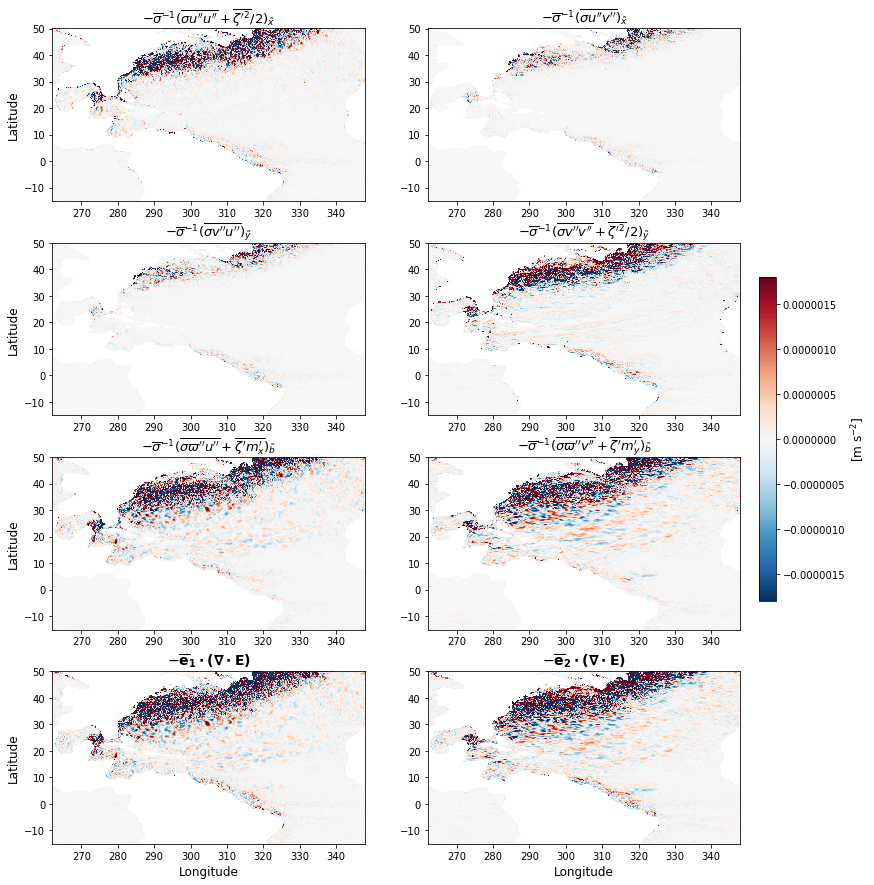

In [7]:
nremap = 140

for year in range(1963,1964):
    if year == 1963:
        ntimes = np.arange( 943920    , 943920+dnf,dnf,dtype=int)
        ystart = ySstart
    else:
        ystart = yNstart
        if year == 1964:
            ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
        elif year == 1965:
            ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
        elif year == 1966:
            ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
        else:
            ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
        
    for itime in ntimes:
#         ds1 = xr.open_dataset(op.join(savedir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
#                                       % (year,nremap,itime))
#                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                    YG=slice(ystart-12**-1,yend+2*12**-1)
#                                   ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
#         ds2 = xr.open_dataset(op.join(savedir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
#                                       % (year,nremap,itime))
#                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                    YG=slice(ystart-12**-1,yend+2*12**-1)
#                                   ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
#         ds3 = xr.open_dataset(op.join(savedir,
#                                       '%4d/Varpidz-compressible_membs_parallel-%2d_%010d.nc' 
#                                       % (year,nremap,itime))
#                              ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                                   ).chunk({'nmemb':membchunk,'XC':xchunk})
        ds1 = xr.open_zarr(op.join(savedir,'Delta/%4d/Zs/%07d/' % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               )
        ds2 = xr.open_zarr(op.join(savedir,'Delta/%4d/Dyns/%07d/' % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                YG=slice(ystart-12**-1,yend+2*12**-1)
                               )
        ds3 = xr.open_zarr(op.join(savedir,'Delta/%4d/Varpi/%07d/' % (year,itime))
                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                               )
        buoyb = -grav * ds1.sig * rhoConst**-1
        buoybp1 = -grav * ds1.sigp1 * rhoConst**-1

        grid = Grid(ds1, periodic=['X'], 
                    coords={'Z':{'center':'sig','outer':'sigp1'},
                            'Y':{'center':'YC','left':'YG'},
                            'X':{'center':'XC','left':'XG'}}
                   )

###############################    
        sigma = ds1.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmay = ds1.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
        sigmax = ds1.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

        zetab = (ds1.zdz*ds1.dzetaF**-1).mean('nmemb',skipna=True)
        zetaxb = (ds1.zxdz*ds1.dzetaFx**-1).mean('nmemb',skipna=True)
        zetayb = (ds1.zydz*ds1.dzetaFy**-1).mean('nmemb',skipna=True)

        sigmab = (ds1.dzetaF.mean('nmemb',skipna=True) 
                  * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                 )
        sigmaxb = (ds1.dzetaFx.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )
        sigmayb = (ds1.dzetaFy.mean('nmemb',skipna=True) 
                   * -grid.diff(buoybp1,'Z',boundary='fill')**-1
                  )

        vhat = ds2.vdz.mean('nmemb',skipna=True) * ds1.dzetaFy.mean('nmemb',skipna=True)**-1
        uhat = ds2.udz.mean('nmemb',skipna=True) * ds1.dzetaFx.mean('nmemb',skipna=True)**-1
        varpihat = ds3.varpidz.mean('nmemb',skipna=True) * ds1.dzetaF.mean('nmemb',skipna=True)**-1

        vpp = ds2.vdz*ds1.dzetaFy**-1 - vhat
        upp = ds2.udz*ds1.dzetaFx**-1 - uhat
        varpipp = ds3.varpidz*ds1.dzetaF**-1 - varpihat

        zetap = (ds1.zdz*ds1.dzetaF**-1 - zetab) 
        zetayp = (ds1.zydz*ds1.dzetaFy**-1 - zetayb)
        zetaxp = (ds1.zxdz*ds1.dzetaFx**-1 - zetaxb)

        mbx = ds2.pxdz * ds1.dzetaFx**-1
        mby = ds2.pydz * ds1.dzetaFy**-1
        mbxp = mbx - mbx.mean('nmemb',skipna=True)
        mbyp = mby - mby.mean('nmemb',skipna=True)

############################### 
#         tmp00 = ((upp**2*sigmax)
#                  + .5*(zetaxp**2)
#                 ).mean('nmemb',skipna=True)
        tmp00_0 = (upp**2*sigmax).mean('nmemb',skipna=True)
        tmp00_1 = .5*(zetaxp**2).mean('nmemb',skipna=True)
#         tmp11 = ((vpp**2*sigmay) 
#                  + .5*(zetayp**2)
#                 ).mean('nmemb',skipna=True)
        tmp11_0 = (vpp**2*sigmay).mean('nmemb',skipna=True)
        tmp11_1 = .5*(zetayp**2).mean('nmemb',skipna=True)
        tmp01 = (grid.interp(grid.interp(vpp,'X'),'Y',boundary='fill')
                 * upp*sigmax).mean('nmemb',skipna=True)
        tmp10 = (grid.interp(grid.interp(upp,'X'),'Y',boundary='fill') 
                 * vpp*sigmay).mean('nmemb',skipna=True)
#         tmp20 = ((varpipp*grid.interp(upp,'X')*sigma)
#                  + grid.interp(mbxp*zetaxp,'X')
#                 ).mean('nmemb',skipna=True)
#         tmp21 = ((varpipp*grid.interp(vpp,'Y',boundary='fill')*sigma)
#                  + grid.interp(mbyp*zetayp,'Y',boundary='fill')
#                 ).mean('nmemb',skipna=True)
        tmp20_0 = (varpipp*grid.interp(upp,'X')
                   * sigma
                  ).mean('nmemb',skipna=True)
        tmp20_1 = grid.interp(mbxp*zetaxp,'X').mean('nmemb',skipna=True)
        tmp21_0 = (varpipp*grid.interp(vpp,'Y',boundary='fill')
                   * sigma
                  ).mean('nmemb',skipna=True)
        tmp21_1 = grid.interp(mbyp*zetayp,'Y',boundary='fill').mean('nmemb',skipna=True)


###############################    
        start = time.time()
        e00 = ((tmp00_0+tmp00_1) * sigmaxb**-1).compute()
        e01 = (tmp01 * sigmaxb**-1).compute()
        e10 = (tmp10 * sigmayb**-1).compute()
        e11 = ((tmp11_0+tmp11_1) * sigmayb**-1).compute()
#         e20 = ((tmp20_0+tmp20_1) * sigmab**-1).compute()
#         e21 = ((tmp21_0+tmp21_1) * sigmab**-1).compute()
        e20_0 = (tmp20_0 * sigmab**-1).compute()
        e20_1 = (tmp20_1 * sigmab**-1).compute()
        e21_0 = (tmp21_0 * sigmab**-1).compute()
        e21_1 = (tmp21_1 * sigmab**-1).compute()
    
#         dsave = e00.to_dataset(name='e00')
#         dsave['e01'] = e01
#         dsave['e10'] = e10
#         dsave['e11'] = e11
#         dsave['e20'] = e20
#         dsave['e21'] = e21
#         dsave.coords['YG'] = ('YG',ds1.YG.data)
#         dsave.coords['XG'] = ('XG',ds1.XG.data)
#         dsave.coords['sigp1'] = ('sigp1',ds1.sigp1)
#         dsave.to_netcdf(op.join(savedir,'%4d/E-P_flux_parallel-%2d_%010d.nc' 
#                                 % (year,nremap,itime)), mode='w')
#         dsave.to_zarr(op.join(savedir,'%4d/E-P/%7d' % (year,itime)))
#         dsave.close()

#         del e00, e01, e10, e11, e20, e21
###############################  
        e00_x = ((grid.diff(tmp00_0*ds.dyG,'X') * ds.rA**-1
                  + grid.diff(tmp00_1,'X') * grid.interp(ds.dxG,'Y',boundary='fill')**-1
                 ) * sigmab**-1).compute()
        e10_y = (grid.diff(tmp10*ds.dxG,'Y',boundary='fill') * ds.rA**-1 
                 * sigmab**-1).compute()
#         e20_b = (grid.interp(grid.diff((tmp20_0+tmp20_1),'Z',boundary='fill') 
#                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                              'Z',boundary='fill')
#                  * sigmab**-1).compute()
        e01_x = (grid.diff(tmp01*ds.dyG,'X') * ds.rA**-1 
                 * sigmab**-1).compute()
        e11_y = ((grid.diff(tmp11_0*ds.dxG,'Y',boundary='fill') * ds.rA**-1
                  + grid.diff(tmp11_1,'Y',boundary='fill') * grid.interp(ds.dyG,'X')**-1
                 ) * sigmab**-1).compute()
#         e21_b = (grid.interp(grid.diff((tmp21_0+tmp21_1),'Z',boundary='fill') 
#                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
#                              'Z',boundary='fill') 
#                  * sigmab**-1).compute()
        e20_0b = (grid.interp(grid.diff(tmp20_0,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        e20_1b = (grid.interp(grid.diff(tmp20_1,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        e21_0b = (grid.interp(grid.diff(tmp21_0,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        e21_1b = (grid.interp(grid.diff(tmp21_1,'Z',boundary='fill') 
                              * grid.diff(buoyb,'Z',boundary='fill')**-1,
                              'Z',boundary='fill')
                  * sigmab**-1).compute()
        
        if itime == 943920 or itime % (20*dnf) == 0:
            e20_b = e20_0b + e20_1b
            e21_b = e21_0b + e21_1b
            Eu = e00_x + e10_y + e20_b
            Ev = e01_x + e11_y + e21_b
            fig, axes = plt.subplots(figsize=(13,15), nrows=4, ncols=2)

            im = axes[0,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                      -e00_x.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                      vmax=1.8e-6, vmin=-1.8e-6, 
                                      cmap='RdBu_r', rasterized=True)
            axes[1,0].pcolormesh(e10_y.XC, e10_y.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                 -e10_y.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                 vmax=1.8e-6, vmin=-1.8e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[0,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                 -e01_x.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                 vmax=1.8e-6, vmin=-1.8e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[1,1].pcolormesh(e11_y.XC, e11_y.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                 -e11_y.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                 vmax=1.8e-6, vmin=-1.8e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[2,0].pcolormesh(e20_b.XC, e20_b.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                 -e20_b.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                 vmax=1.8e-6, vmin=-1.8e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[2,1].pcolormesh(e21_b.XC, e21_b.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                 -e21_b.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                 vmax=1.8e-6, vmin=-1.8e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[3,0].pcolormesh(e00_x.XC, e00_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                 -Eu.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                 vmax=1.8e-6, vmin=-1.8e-6, 
                                 cmap='RdBu_r', rasterized=True)
            axes[3,1].pcolormesh(e01_x.XC, e01_x.YC.sel(YC=slice(ystart-12**-1,yend+2*12**-1)),
                                 -Ev.sel(YC=slice(ystart-12**-1,yend+2*12**-1)).isel(sig=30),
                                 vmax=1.8e-6, vmin=-1.8e-6, 
                                 cmap='RdBu_r', rasterized=True)

            axes[0,0].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma u''u''} + \overline{\zeta'^2}/2)_\tilde{x}$", 
                                fontsize=13)
            axes[1,0].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma v''u''})_\tilde{y}$", 
                                fontsize=13)
            axes[0,1].set_title(r"$-\overline{\sigma}^{-1}(\overline{\sigma u''v''})_\tilde{x}$", 
                                fontsize=13)
            axes[1,1].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma v''v''} + \overline{\zeta'^2}/2)_\tilde{y}$", 
                                fontsize=13)
            axes[2,0].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma \varpi''u''} + \overline{\zeta'm_x'})_\tilde{b}$", 
                                fontsize=13)
            axes[2,1].set_title(r"$-\overline{\sigma}^{-1}($"
                                + r"$\overline{\sigma \varpi''v''} + \overline{\zeta'm_y'})_\tilde{b}$", 
                                fontsize=13)
            axes[3,0].set_title(r"$-\overline{\bf e}_1\cdot(\nabla\cdot{\bf E})$", fontsize=14)
            axes[3,1].set_title(r"$-\overline{\bf e}_2\cdot(\nabla\cdot{\bf E})$", fontsize=14)

            axes[3,0].set_xlabel(r"Longitude", fontsize=12)
            axes[3,1].set_xlabel(r"Longitude", fontsize=12)
            axes[0,0].set_ylabel(r"Latitude", fontsize=12)
            axes[1,0].set_ylabel(r"Latitude", fontsize=12)
            axes[2,0].set_ylabel(r"Latitude", fontsize=12)
            axes[3,0].set_ylabel(r"Latitude", fontsize=12)

            fig.subplots_adjust(right=0.86, hspace=0.24)
            cbaxes = fig.add_axes([0.88, 0.35, 0.018, 0.3]) 
            cbar = fig.colorbar(im, orientation='vertical', cax=cbaxes)
            cbar.set_label(r"[m s$^{-2}$]", fontsize=12)

            plt.savefig(op.join(savedir,'Figures/DivE-P_flux_adjusted-delta_%4d-%07d.pdf'
                                % (year,itime)))

        end = time.time()
        print("Lapse time:", end-start)

############################### 
        dsave = e00.to_dataset(name='e00')
        dsave['e01'] = e01
        dsave['e10'] = e10
        dsave['e11'] = e11
    #     dsave['e20'] = e20_0 + e20_1
    #     dsave['e21'] = e21_0 + e21_1
        dsave['e00x'] = e00_x
        dsave['e01x'] = e01_x
        dsave['e10y'] = e10_y
        dsave['e11y'] = e11_y
    #     dsave['e20b'] = e20_0b + e20_1b
    #     dsave['e21b'] = e21_0b + e21_1b
        dsave['e20_0'] = e20_0
        dsave['e20_1'] = e20_1
        dsave['e21_0'] = e21_0
        dsave['e21_1'] = e21_1
        dsave['e20_0b'] = e20_0b
        dsave['e20_1b'] = e20_1b
        dsave['e21_0b'] = e21_0b
        dsave['e21_1b'] = e21_1b
        dsave.coords['YG'] = ('YG',ds1.YG.data)
        dsave.coords['XG'] = ('XG',ds1.XG.data)
        dsave.coords['sigp1'] = ('sigp1',ds1.sigp1)
    #     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
    #                             % (year,nremap,itime)), mode='w')
        dsave.to_zarr(op.join(savedir,'Delta/%4d/E-P/%07d/' % (year,itime)), mode='w')
        dsave.close()

        del e00, e01, e10, e11
        del e00_x, e01_x, e10_y, e11_y
        del e20_0, e20_1, e21_0, e21_1, e20_0b, e20_1b, e21_0b, e21_1b
        ds1.close()
        ds2.close()
        ds3.close()
        print(itime)

    # client.restart()

In [8]:
year = 1963
nremap = 80
ystart = ySstart

ntimes = np.arange( 943920    , 943920+dnf,dnf,dtype=int)
# ntimes = np.arange( 943920+dnf,1101600+dnf,dnf,dtype=int)
# ntimes = np.arange(1101600+dnf,1259280+dnf,dnf,dtype=int)
# ntimes = np.arange(1259280+dnf,1416960+dnf,dnf,dtype=int)
# ntimes = np.arange(1416960+dnf,1574640+dnf,dnf,dtype=int)
for itime in ntimes:
    
    ds1 = xr.open_dataset(op.join(savedir,'%4d/Zs_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime))
                         ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                               YG=slice(ystart-12**-1,yend+2*12**-1)
                              ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
    ds2 = xr.open_dataset(op.join(savedir,'%4d/Dyn_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime))
                         ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                               YG=slice(ystart-12**-1,yend+2*12**-1)
                              ).chunk({'nmemb':membchunk,'XC':xchunk,'XG':xchunk})
    ds3 = xr.open_dataset(op.join(savedir,'%4d/Varpidz-compressible_membs_parallel-%2d_%010d.nc' 
                                  % (year,nremap,itime))
                         ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                              ).chunk({'nmemb':membchunk,'XC':xchunk})
#     ds1 = xr.open_zarr(op.join(savedir,'%4d/Zs/%7d' % (year,itime))
#                       ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                             YG=slice(ystart-12**-1,yend+2*12**-1)
#                            )
#     ds2 = xr.open_zarr(op.join(savedir,'%4d/Dyns/%7d' % (year,itime))
#                       ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                             YG=slice(ystart-12**-1,yend+2*12**-1)
#                            )
#     ds3 = xr.open_zarr(op.join(savedir,'%4d/Varpi/%7d' % (year,itime))
#                       ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                            )
    buoyb = -grav * ds1.sig * rhoConst**-1
    buoybp1 = -grav * ds1.sigp1 * rhoConst**-1

    grid = Grid(ds1, periodic=['X'], 
                coords={'Z':{'center':'sig','outer':'sigp1'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
               )
    
###########################    
    sigma = ds1.dzetaF * -grid.diff(buoybp1,'Z',boundary='fill')**-1
    sigmay = ds1.dzetaFy * -grid.diff(buoybp1,'Z',boundary='fill')**-1
    sigmax = ds1.dzetaFx * -grid.diff(buoybp1,'Z',boundary='fill')**-1

    zetab = (ds1.zdz*ds1.dzetaF**-1).mean('nmemb',skipna=True)
    zetaxb = (ds1.zxdz*ds1.dzetaFx**-1).mean('nmemb',skipna=True)
    zetayb = (ds1.zydz*ds1.dzetaFy**-1).mean('nmemb',skipna=True)
    
    sigmab = (ds1.dzetaF.mean('nmemb',skipna=True) 
              * -grid.diff(buoybp1,'Z',boundary='fill')**-1
             )
    sigmaxb = (ds1.dzetaFx.mean('nmemb',skipna=True) 
               * -grid.diff(buoybp1,'Z',boundary='fill')**-1
              )
    sigmayb = (ds1.dzetaFy.mean('nmemb',skipna=True) 
               * -grid.diff(buoybp1,'Z',boundary='fill')**-1
              )
    
    vhat = ds2.vdz.mean('nmemb',skipna=True) * ds1.dzetaFy.mean('nmemb',skipna=True)**-1
    uhat = ds2.udz.mean('nmemb',skipna=True) * ds1.dzetaFx.mean('nmemb',skipna=True)**-1
    varpihat = ds3.varpidz.mean('nmemb',skipna=True) * ds1.dzetaF.mean('nmemb',skipna=True)**-1

    vpp = ds2.vdz*ds1.dzetaFy**-1 - vhat
    upp = ds2.udz*ds1.dzetaFx**-1 - uhat
    varpipp = ds3.varpidz*ds1.dzetaF**-1 - varpihat

    zetap = (ds1.zdz*ds1.dzetaF**-1 - zetab) 
    zetayp = (ds1.zydz*ds1.dzetaFy**-1 - zetayb)
    zetaxp = (ds1.zxdz*ds1.dzetaFx**-1 - zetaxb)

    mbx = ds2.pxdz * ds1.dzetaFx**-1
    mby = ds2.pydz * ds1.dzetaFy**-1
    mbxp = mbx - mbx.mean('nmemb',skipna=True)
    mbyp = mby - mby.mean('nmemb',skipna=True)
########################### 
    tmp20_0 = (varpipp*grid.interp(upp,'X')
               * sigma
              ).mean('nmemb',skipna=True)
    tmp20_1 = grid.interp(mbxp*zetaxp,'X').mean('nmemb',skipna=True)
    tmp21_0 = (varpipp*grid.interp(vpp,'Y',boundary='fill')
               * sigma
              ).mean('nmemb',skipna=True)
    tmp21_1 = grid.interp(mbyp*zetayp,'Y',boundary='fill').mean('nmemb',skipna=True)

###########################    
    start = time.time()
    e20_0 = (tmp20_0 * sigmab**-1).compute()
    e20_1 = (tmp20_1 * sigmab**-1).compute()
    e21_0 = (tmp21_0 * sigmab**-1).compute()
    e21_1 = (tmp21_1 * sigmab**-1).compute()

###########################  
    e20_0b = (grid.interp(grid.diff(tmp20_0,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    e20_1b = (grid.interp(grid.diff(tmp20_1,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    e21_0b = (grid.interp(grid.diff(tmp21_0,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    e21_1b = (grid.interp(grid.diff(tmp21_1,'Z',boundary='fill') 
                          * grid.diff(buoyb,'Z',boundary='fill')**-1,
                          'Z',boundary='fill')
              * sigmab**-1).compute()
    
    end = time.time()
    print("Lapse time:", end-start)
    
    dsave = e20_0.to_dataset(name='varpipup')
    dsave['zpmxp'] = e20_1
    dsave['varpipvp'] = e21_0
    dsave['zpmyp'] = e21_1
    dsave['varpipup_b'] = e20_0b
    dsave['zpmxp_b'] = e20_1b
    dsave['varpipvp_b'] = e21_0b
    dsave['zpmyp_b'] = e21_1b
    dsave.coords['YG'] = ('YG',ds1.YG.data)
    dsave.coords['XG'] = ('XG',ds1.XG.data)
    dsave.coords['sigp1'] = ('sigp1',ds1.sigp1)
#     dsave.to_netcdf(op.join(savedir,'%4d/divE-P_flux_parallel-%2d_%010d.nc' 
#                             % (year,nremap,itime)), mode='w')
    dsave.to_zarr(op.join(savedir,'%4d/Adiab_barocli/%07d' % (year,itime)))
    dsave.close()
    
    del e20_0, e20_1, e21_0, e21_1
    del e20_0b, e21_0b, e20_1b, e21_1b
    ds1.close()
    ds2.close()
    ds3.close()
    print(itime)
    
# client.restart()

KeyboardInterrupt: 

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('all-aggregate-3990c849e1f1bc2c124f5ff34c0264a4',)": ()}


In [9]:
dsave.to_zarr(op.join(savedir,'%4d/Adiab_barocli/%07d' % (year,itime)))
dsave.close()